In [1]:
import json
import os

In [2]:
conllu_dir = 'data/PreTENS/profiling_output/linguistic_annotation'
sentences_info_path = 'data/PreTENS/preprocessed_dataset/sentences_info.json'

# Regressione

Proveremo a risolvere il task PreTENS rappresentando i documenti utlizzando:
   - ngrammi
   - word embeddings

## Vedremo anche come scegliere tra due modeli

# Caricamento dataset

Creiamo un dizionario che associa ad ogni documento:
   - Split: train/test
   - Score: il punteggio GOLD di accettabilità da predire

In [3]:
def load_info_dict(src_path):
    with open(src_path, 'r') as src_file:
        info_dict = json.load(src_file)
    return info_dict

In [4]:
document_info_dict = load_info_dict(sentences_info_path)

In [5]:
document_info_dict;

## Creazione delle rappresentazioni dei documento

Carichiamo i token del documento in modo che possiamo già estrarre entrambi i set di features:

Per ogni documento estraiamo quindi la sua lista di token, portandoci dietro anche le POS (utili sia se vogliamo filtrare i Word Embeddings, sia se vogliamo estrarre gli n-grammi di POS)

### Estrazione token dei documenti dai file .conllu (Codice laboratorio 3)

In [6]:
import re


def get_digits(text):
    try:
        val = int(text)
    except:
        text = re.sub(r'\d', '@Dg', text)
        return text
    if val >= 0 and val < 2100:
        return str(val)
    else:
        return "DIGLEN_" + str(len(str(val)))


def normalize_text(word):
    if "http" in word or ("." in word and "/" in word):
        word = str("___URL___")
        return word
    if len(word) > 26:
        return "__LONG-LONG__"
    new_word = get_digits(word)
    if new_word != word:
        word = new_word
    if word[0].isupper():
        word = word.capitalize()
    else:
        word = word.lower()
    return word


def get_tokens_from_file(src_path):
    document_tokens = []
    lines_to_skip = 0
    take_pos = False
    for line in open(src_path, 'r'):
        if line[0].isdigit():
            splitted_line = line.strip().split('\t')
            if '-' in splitted_line[0]:
                skip_ids = splitted_line[0].split('-')
                lines_to_skip = int(skip_ids[1]) - int(skip_ids[0]) + 1  # l'indice ci indica quali righe saltare
                take_pos = True
                word = normalize_text(splitted_line[1])
                pos = splitted_line[3]
                token = {
                    'word': word,
                    'pos': pos
                }
                document_tokens.append(token)
            else:
                if lines_to_skip == 0:
                    word = normalize_text(splitted_line[1])
                    pos = splitted_line[3]
                    token = {
                        'word': word,
                        'pos': pos
                    }
                    document_tokens.append(token)
                if take_pos:
                    pos = splitted_line[3]
                    document_tokens[-1]['pos'] = pos
                    take_pos = False
                lines_to_skip = max(0, lines_to_skip - 1)
    return document_tokens

In [7]:
def load_all_documents_dict(src_dir):
    documents_dict = dict()
    for file_name in os.listdir(src_dir):
        document_id = file_name.split('.')[0]
        document_path = os.path.join(src_dir, file_name)
        document_tokens = get_tokens_from_file(document_path)
        documents_dict[document_id] = document_tokens
    return documents_dict

In [8]:
documents_dict = load_all_documents_dict(conllu_dir)

In [9]:
sample_document_id = list(documents_dict.keys())[0]
print('Document id:', sample_document_id)
print('Document tokens:')
print(documents_dict[sample_document_id])
print('Document split:', document_info_dict[sample_document_id]['split'])
print('Document score:', document_info_dict[sample_document_id]['score'])

Document id: test_it_846
Document tokens:
[{'word': 'Apprezzo', 'pos': 'VERB'}, {'word': 'i', 'pos': 'DET'}, {'word': 'guardiani', 'pos': 'NOUN'}, {'word': ',', 'pos': 'PUNCT'}, {'word': 'ma', 'pos': 'CCONJ'}, {'word': 'non', 'pos': 'ADV'}, {'word': 'i', 'pos': 'DET'}, {'word': 'ministri', 'pos': 'NOUN'}, {'word': '.', 'pos': 'PUNCT'}]
Document split: test
Document score: 3.82


# 1) Rappresento i documenti usando gli n-grammi

## Estrazione features (n-grammi) (Codice laboratorio 2 senza classi)

In [10]:
def extract_word_ngrams(word_ngrams, sentence, el, n):
    # creiamo una lista con tutte le parole
    all_words = []
    for token in sentence:
        all_words.append(token[el])

    # scorriamo la lista delle parole e estraiamo gli n-grammi
    for i in range(0, len(all_words) - n + 1):
        ngram_words = all_words[i: i + n]
        ngram = f'{el.upper()}_{n}_' + '_'.join(ngram_words)
        if ngram not in word_ngrams:
            word_ngrams[ngram] = 1
        else:
            word_ngrams[ngram] += 1

    return word_ngrams


def extract_char_ngrams(char_ngrams, sentence, n):
    # creiamo una lista con tutte le parole
    all_words = []
    for token in sentence:
        all_words.append(token['word'])

    # creiamo una stringa che contenga tutte le parole separate tra spazi perchè vogliamo scorrere i caratteri
    all_words = ' '.join(all_words)

    # scorriamo la stringa ed estraiamo gli n-grammi di caratteri
    for i in range(0, len(all_words) - n + 1):
        ngram_chars = all_words[i:i + n]
        ngram = f'CHAR_{n}_' + ngram_chars

        if ngram not in char_ngrams:
            char_ngrams[ngram] = 1
        else:
            char_ngrams[ngram] += 1

    return char_ngrams


def normalize_ngrams(ngrams_dict, doc_len):
    for ngram in ngrams_dict:
        ngrams_dict[ngram] = ngrams_dict[ngram] / float(doc_len)

In questo caso non stiamo classificando documenti ma frasi, quindi l'estrazione delle features ha un ciclo for in meno rispetto a quello visto nel laboratorio 2.

In [11]:
def extract_ngrams(all_documents):
    ngrams_dict = dict()
    for document_id, sentence in all_documents.items():
        word_unigrams = extract_word_ngrams(dict(), sentence, 'word', 1)
        word_bigrams = extract_word_ngrams(dict(), sentence, 'word', 2)
        pos_unigrams = extract_word_ngrams(dict(), sentence, 'pos', 1)
        pos_bigrams = extract_word_ngrams(dict(), sentence, 'pos', 2)
        char_unigrams = extract_char_ngrams(dict(), sentence, 1)
        char_bigrams = extract_char_ngrams(dict(), sentence, 2)

        num_words = len(sentence)
        num_chars = 0
        for token in sentence:
            num_chars = num_chars + len(token['word'])

        normalize_ngrams(word_unigrams, num_words)
        normalize_ngrams(word_bigrams, num_words)
        normalize_ngrams(pos_unigrams, num_words)
        normalize_ngrams(pos_bigrams, num_words)
        normalize_ngrams(char_unigrams, num_chars)
        normalize_ngrams(char_bigrams, num_chars)

        sentence_features = word_unigrams | word_bigrams | pos_unigrams | pos_bigrams | char_unigrams | char_bigrams

        ngrams_dict[document_id] = sentence_features
    return ngrams_dict

In [12]:
ngrams_dict = extract_ngrams(documents_dict)

In [13]:
ngrams_dict[sample_document_id];

# Split train test

In [14]:
len(documents_dict), len(ngrams_dict), len(document_info_dict)

(1533, 1533, 1533)

In [15]:
def train_test_split(features_dict, document_info_dict):
    train_features, train_scores = [], []
    test_features, test_scores = [], []

    for document_id in features_dict.keys():
        if document_info_dict[document_id]['split'] == 'train':
            train_features.append(features_dict[document_id])
            train_scores.append(document_info_dict[document_id]['score'])
        else:
            test_features.append(features_dict[document_id])
            test_scores.append(document_info_dict[document_id]['score'])

    return train_features, train_scores, test_features, test_scores

In [16]:
train_features_ngrams, train_scores, test_features_ngrams, test_scores = train_test_split(ngrams_dict, document_info_dict)

In [17]:
len(train_features_ngrams), len(train_scores), len(test_features_ngrams), len(test_scores)

(524, 524, 1009, 1009)

In [18]:
def get_num_features(dataset):
    all_features = set()
    for user_dict in dataset:
        all_features.update(list(user_dict.keys()))
    return len(all_features)

In [19]:
print(f'Numero features: {get_num_features(train_features_ngrams)}')

Numero features: 479


## Creazione matrice delle features

In [20]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MaxAbsScaler

vectorizer_ngrams = DictVectorizer()
X_train_ngrams = vectorizer_ngrams.fit_transform(train_features_ngrams)

scaler_ngrams = MaxAbsScaler()
X_train_ngrams = scaler_ngrams.fit_transform(X_train_ngrams)

## Addestramento del modello

In [21]:
from sklearn.svm import LinearSVR

svr_ngrams = LinearSVR(max_iter=10000)
svr_ngrams.fit(X_train_ngrams, train_scores)

LinearSVR(max_iter=10000)

# Per un attimo facciamo finta di avere il test set così vediamo le metriche di valutazione

In [22]:
X_test_ngrams = vectorizer_ngrams.transform(test_features_ngrams)
X_test_ngrams = scaler_ngrams.transform(X_test_ngrams)

test_predictions_ngrams = svr_ngrams.predict(X_test_ngrams)

In [23]:
test_predictions_ngrams

array([2.68207336, 3.6865468 , 4.15502211, ..., 3.58176727, 3.89631266,
       1.15539085], shape=(1009,))

# Valutazione regressore
## Per prima cosa creiamoci una baseline

In [24]:
from sklearn.dummy import DummyRegressor

baseline_regressor = DummyRegressor(strategy="mean")
baseline_regressor.fit(X_train_ngrams, train_scores)
baseline_predictions = baseline_regressor.predict(X_test_ngrams)

## Misure di correlazione

La correlazione è il grado con cui due variabili sono "legate" linearmente.

### Correlazione di Pearson

È un indice che misura la presenza di una correlazione lineare tra due variabili.
ha un valore compreso tra +1 e -1, dove +1 corrisponde alla perfetta correlazione lineare positiva, 0 corrisponde a un'assenza di correlazione lineare e -1 corrisponde alla perfetta correlazione lineare negativa.

<br />

$$
\rho_{x,y} = \frac{\sigma_{xy}}{\sigma_x\sigma_y}
$$

<br />

Può essere utilizzata solo per calcolare la correlazione tra due variabili continue.

### Correlazione di Spearman

La correlazione di Spearman misura la presenza di una relazione tra l'ordinamento di due variabili. Differentemente da Pearson si basa **solo** sull'ordinamento dei valori, non sui valori stessi. Può essere quindi utilizzata sia per variabili continue, sia per valriabili ordinali.

![Correlation](data/img/correlation.png)

In [25]:
from scipy.stats import spearmanr, pearsonr

s_corr = spearmanr(test_scores, test_predictions_ngrams)
p_corr = pearsonr(test_scores, test_predictions_ngrams)

print('Correlazione di Spearman = ', round(s_corr.statistic, 4), ', p-value =', s_corr.pvalue)
print('Correlazione di Pearson = ', round(p_corr.statistic, 4), ', p-value =', p_corr.pvalue)

Correlazione di Spearman =  0.0696 , p-value = 0.027102362106704157
Correlazione di Pearson =  0.1294 , p-value = 3.748942656961647e-05


In [26]:
s_corr = spearmanr(test_scores, baseline_predictions)
p_corr = pearsonr(test_scores, baseline_predictions)

print('BASELINE')
print('Correlazione di Spearman = ', round(s_corr.statistic, 4), ', p-value =', s_corr.pvalue)
print('Correlazione di Pearson = ', round(p_corr.statistic, 4), ', p-value =', p_corr.pvalue)

BASELINE
Correlazione di Spearman =  nan , p-value = nan
Correlazione di Pearson =  nan , p-value = nan


/tmp/ipykernel_11404/3516966886.py:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  s_corr = spearmanr(test_scores, baseline_predictions)
/tmp/ipykernel_11404/3516966886.py:2: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  p_corr = pearsonr(test_scores, baseline_predictions)


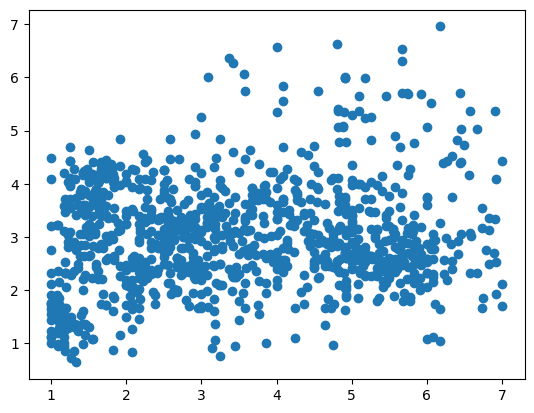

In [27]:
import matplotlib.pyplot as plt
plt.scatter(test_scores, test_predictions_ngrams)

## Errori

1) Mean Absolute Error (MAE): rappresenta la media della differenza tra i valori predetti e i valori reali in valore assoluto. (Media degli errori)

<br />

$$
MAE = \frac{1}{n}\sum_{i=1}^n\left|Y_{true_i}-Y_{pred_i}\right|
$$

<br />


2) Mean Squared Error (MSE): rappresenta la media delle differenze al quadrato tra i valori predetti e i valori reali. (Varianza degli errori)

<br />

$$
MSE = \frac{1}{n}\sum_{i=1}^n\left(Y_{true_i}-Y_{pred_i}\right)^2
$$

<br />

3) Root Mean Squared Error (RMSE): è la radice quadrata dell'MSE. In questo modo l'errore è di nuovo nella scala dei valori predetti. (Deviazione standard degli errori)

<br />

$$
RMSE = \sqrt{MSE} =  \frac{1}{n}\sqrt{\sum_{i=1}^n\left(Y_{true_i}-Y_{pred_i}\right)^2}
$$

<br />


Per tutte queste metriche, più e basso il valore ottenuto, migliore è il modello.

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error

print('MAE =', mean_absolute_error(test_scores, test_predictions_ngrams))
print('MSE = ', mean_squared_error(test_scores, test_predictions_ngrams))
print('RMSE =', root_mean_squared_error(test_scores, test_predictions_ngrams))

MAE = 1.5044786730626771
MSE =  3.533403069850871
RMSE = 1.8797348403035123


In [29]:
print('BASELINE')
print('MAE =', mean_absolute_error(test_scores, baseline_predictions))
print('MSE = ', mean_squared_error(test_scores, baseline_predictions))
print('RMSE =', root_mean_squared_error(test_scores, baseline_predictions))

BASELINE
MAE = 1.5178795232222968
MSE =  3.05124532695954
RMSE = 1.7467814193423115


### Coefficiente di determinazione (R2 score)

L'R2 score è un indice che misura quanto il modello riesce a spiegare la variabilità della variabile dipendente (gli score da predire).


<br />

$
R^2 = 1 - \frac{RSS}{TSS}
$

<br />


dove:

<br />

$
RSS = \sum_{i=1}^n (Y\_true_i - Y\_pred_i)^2
$

e

$
TSS = \sum_{i=1}^n (Y\_true_i - Y\_mean)^2
$

<br />


Se lo score R2 è vicino ad 1, significa che il regressore predice bene il valore della variabile dipendente.

![r2_score](data/img/r2_score.png)


Indica quanto il modello è migliore rispetto al modello che predice sempre il valore medio

In [30]:
from sklearn.metrics import r2_score
print('R2 =', r2_score(test_scores, test_predictions_ngrams))

R2 = -0.3163411210405971


In [31]:
print('BASELINE')
print('R2 =', r2_score(test_scores, baseline_predictions))

BASELINE
R2 = -0.13671710100974166


# Ritorniamo alla selezione del modello
## 2) Rappresento i documenti utilizzando i word embeddings

In [32]:
embeddings_dim = 32
embeddings_path = f'data/word_embeddings/itwac{embeddings_dim}.txt'

## Carico il dizionario dei word embeddings (Codice lezione 3)

In [33]:
import numpy as np

def load_word_embeddings(src_path):
    embeddings = dict()
    for line in open(src_path, 'r'):
        line = line.strip().split('\t')
        word = line[0]
        embedding = line[1:]
        embedding = [float(comp) for comp in embedding] # convertiamo le componenti dell'embedding in float
        embeddings[word] = np.asarray(embedding) # trasformiamo la lista delle componenti in un vettore di numpy
    return embeddings

In [34]:
embeddings = load_word_embeddings(embeddings_path)

### Creo le rappresentazioni dei documenti utilizzando i word embeddings (codice lezione 3)

Faccio la media dei word embeddings dei **SOSTANTIVI**

In [35]:
def compute_embeddings_mean(document_embeddings):
    sum_array = np.sum(document_embeddings, axis=0)
    mean_array = np.divide(sum_array, len(document_embeddings))
    return mean_array

def compute_all_embeddings_mean(sentence_tokens):
    document_embeddings = []
    
    for token in sentence_tokens:
        word = token['word']
        if word in embeddings and token['pos'] == 'NOUN': ## prendo solo i sostantivi
            document_embeddings.append(embeddings[word])
    
    if len(document_embeddings) == 0:
        mean_document_embeddings = np.zeros(embeddings_dim)
    else:
        mean_document_embeddings = compute_embeddings_mean(document_embeddings)
    return mean_document_embeddings

def extract_embedding_features(documents_dict):
    embeddings_dict = dict()
    for document_id, document_tokens in documents_dict.items():
        document_embeddings = compute_all_embeddings_mean(document_tokens)
        embeddings_dict[document_id] = document_embeddings
    return embeddings_dict

In [36]:
embeddings_dict = extract_embedding_features(documents_dict)

In [37]:
embeddings_dict[sample_document_id]

array([ 0.0365308 ,  0.00811744, -0.06340349, -0.01574489,  0.22701907,
        0.1162882 ,  0.15505953,  0.26535071,  0.06309327, -0.09789488,
       -0.06113949, -0.17304534,  0.08831078,  0.21927223, -0.10000752,
        0.26870348, -0.25398186, -0.01579346, -0.17949711, -0.01194552,
        0.09504516,  0.01972278,  0.12636615, -0.01965856,  0.11567362,
        0.24920382, -0.14953592,  0.0965906 , -0.09670024,  0.19184153,
        0.02030137, -0.002033  ])

In [38]:
train_features_embs, _, test_features_embs, _ = train_test_split(embeddings_dict, document_info_dict)

In [39]:
len(train_features_embs), len(train_scores), len(test_features_embs), len(test_scores)

(524, 524, 1009, 1009)

## Creazione della matrice delle features

**Ricordiamoci di usare uno scaler diverso da quello di prima!!**

In [40]:
from sklearn.preprocessing import MinMaxScaler

scaler_embs = MinMaxScaler()
X_train_embs = scaler_embs.fit_transform(train_features_embs)

In [41]:
X_train_embs.shape

(524, 32)

## Addestramento modello

In [42]:
svr_embs = LinearSVR(max_iter=10000)
svr_embs.fit(X_train_embs, train_scores)

LinearSVR(max_iter=10000)

# Se non abbiamo il test set, come scegliamo il modello?
## Con la cross-validation

In [43]:
from sklearn.model_selection import KFold

splitter = KFold(n_splits=10, random_state=42, shuffle=True)
folds = list(splitter.split(range(len(train_features_ngrams))))

In [44]:
folds[0];

In [45]:
y_train = np.asarray(train_scores)

In [46]:
y_train;

In [49]:
all_y_true = []
all_y_pred_ngrams = []
all_y_pred_embs = []

for i in range(len(folds)):
    train_ids = folds[i][0]
    test_ids = folds[i][1]

    fold_X_train_ngrams = X_train_ngrams[train_ids]
    fold_X_train_embs = X_train_embs[train_ids]
    fold_y_train = y_train[train_ids]

    fold_X_test_ngrams = X_train_ngrams[test_ids]
    fold_X_test_embs = X_train_embs[test_ids]
    fold_y_test = y_train[test_ids]
    all_y_true += fold_y_test.tolist()

    # Fit ngrams
    fold_scaler_ngrams = MaxAbsScaler()
    fold_X_train_ngrams = fold_scaler_ngrams.fit_transform(fold_X_train_ngrams)
    fold_X_test_ngrams = fold_scaler_ngrams.transform(fold_X_test_ngrams)
    fold_svr_ngrams = LinearSVR(dual=True, max_iter=10000)
    fold_svr_ngrams.fit(fold_X_train_ngrams, fold_y_train)
    fold_y_pred_ngrams = fold_svr_ngrams.predict(fold_X_test_ngrams)
    all_y_pred_ngrams += fold_y_pred_ngrams.tolist()
    
    # Fit embeddings
    fold_scaler_embs = MinMaxScaler()
    fold_X_train_embs = fold_scaler_embs.fit_transform(fold_X_train_embs)
    fold_X_test_embs = fold_scaler_embs.transform(fold_X_test_embs)
    fold_svr_embs = LinearSVR(dual=True, max_iter=10000)
    fold_svr_embs.fit(fold_X_train_embs, fold_y_train)
    fold_y_pred_embs = fold_svr_embs.predict(fold_X_test_embs)
    all_y_pred_embs += fold_y_pred_embs.tolist()

    # Print scores
    print(f'FOLD {i+1}')
    print(f'Spearman:\n Ngrams: {spearmanr(fold_y_test, fold_y_pred_ngrams).statistic}, Embeddings: {spearmanr(fold_y_test, fold_y_pred_embs).statistic}')    
    print(f'MSE:\n Ngrams: {mean_squared_error(fold_y_test, fold_y_pred_ngrams)}, Embeddings: {mean_squared_error(fold_y_test, fold_y_pred_embs)}')    
    print(f'R2 score:\n Ngrams: {r2_score(fold_y_test, fold_y_pred_ngrams)}, Embeddings: {r2_score(fold_y_test, fold_y_pred_embs)}')
    print('\n____________________________________________________________\n')

print('OVERALL METRICS')
print(f'Spearman:\n Ngrams: {spearmanr(all_y_true, all_y_pred_ngrams).statistic}, Embeddings: {spearmanr(all_y_true, all_y_pred_embs).statistic}')    
print(f'MSE:\n Ngrams: {mean_squared_error(all_y_true, all_y_pred_ngrams)}, Embeddings: {mean_squared_error(all_y_true, all_y_pred_embs)}')    
print(f'R2 score:\n Ngrams: {r2_score(all_y_true, all_y_pred_ngrams)}, Embeddings: {r2_score(all_y_true, all_y_pred_embs)}')

FOLD 1
Spearman:
 Ngrams: 0.8268812243005137, Embeddings: 0.5221845756695709
MSE:
 Ngrams: 1.1526126676841997, Embeddings: 1.762714594336074
R2 score:
 Ngrams: 0.6449861401331418, Embeddings: 0.4570698990874267

____________________________________________________________

FOLD 2
Spearman:
 Ngrams: 0.7853585598329806, Embeddings: 0.7234750974289735
MSE:
 Ngrams: 0.8993889838134075, Embeddings: 1.1004879112316068
R2 score:
 Ngrams: 0.7375080652029175, Embeddings: 0.6788161671547502

____________________________________________________________

FOLD 3
Spearman:
 Ngrams: 0.8239137292828892, Embeddings: 0.6628622238177617
MSE:
 Ngrams: 0.8228117338259711, Embeddings: 1.1599445307301588
R2 score:
 Ngrams: 0.7286380792249096, Embeddings: 0.6174522519411823

____________________________________________________________

FOLD 4
Spearman:
 Ngrams: 0.7508721332310492, Embeddings: 0.5065652797577335
MSE:
 Ngrams: 1.0503690360646725, Embeddings: 1.7358577924847294
R2 score:
 Ngrams: 0.6838797887146

# Test dei modelli
## Ngrammi

In [50]:
X_test_ngrams = vectorizer_ngrams.transform(test_features_ngrams)
X_test_ngrams = scaler_ngrams.transform(X_test_ngrams)

test_predictions_ngrams = svr_ngrams.predict(X_test_ngrams)

s_corr = spearmanr(test_scores, test_predictions_ngrams)
p_corr = pearsonr(test_scores, test_predictions_ngrams)
print('Correlazione di Spearman = ', round(s_corr.statistic, 4), ', p-value =', s_corr.pvalue)
print('Correlazione di Pearson = ', round(p_corr.statistic, 4), ', p-value =', p_corr.pvalue)

print('MAE =', mean_absolute_error(test_scores, test_predictions_ngrams))
print('MSE = ', mean_squared_error(test_scores, test_predictions_ngrams))
print('RMSE =', root_mean_squared_error(test_scores, test_predictions_ngrams))

print('R2 =', r2_score(test_scores, test_predictions_ngrams))

Correlazione di Spearman =  0.0696 , p-value = 0.027102362106704157
Correlazione di Pearson =  0.1294 , p-value = 3.748942656961647e-05
MAE = 1.5044786730626771
MSE =  3.533403069850871
RMSE = 1.8797348403035123
R2 = -0.3163411210405971


## Word embeddings

In [51]:
X_test_embs = scaler_embs.transform(test_features_embs)

test_predictions_embs = svr_embs.predict(X_test_embs)

s_corr = spearmanr(test_scores, test_predictions_embs)
p_corr = pearsonr(test_scores, test_predictions_embs)
print('Correlazione di Spearman = ', round(s_corr.statistic, 4), ', p-value =', s_corr.pvalue)
print('Correlazione di Pearson = ', round(p_corr.statistic, 4), ', p-value =', p_corr.pvalue)

print('MAE =', mean_absolute_error(test_scores, test_predictions_embs))
print('MSE = ', mean_squared_error(test_scores, test_predictions_embs))
print('RMSE =', root_mean_squared_error(test_scores, test_predictions_embs))

print('R2 =', r2_score(test_scores, test_predictions_embs))

Correlazione di Spearman =  0.0703 , p-value = 0.02555003707788955
Correlazione di Pearson =  0.1252 , p-value = 6.714387451982678e-05
MAE = 2.3892642536228506
MSE =  9.185009291119014
RMSE = 3.0306780249836858
R2 = -2.4218019252329994
